# Advanced Stock Forecasting with LSTM and News Sentiment Analysis

This comprehensive notebook merges LSTM-based stock price forecasting with news sentiment analysis to create an advanced predictive model. The workflow includes:

1. **Automated Stock Selection** from news data
2. **Sentiment Analysis** using FinBERT on news headlines
3. **Feature Engineering** with sentiment scores and technical indicators
4. **Baseline LSTM Model** using only technical indicators
5. **Enhanced LSTM Model** incorporating news sentiment
6. **Performance Comparison** between both models


In [1]:
stock_symbol = 'EBAY'

## 1. Import Required Libraries and Configuration


In [2]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install yfinance
# !pip install scikit-learn
# !pip install tensorflow
# !pip install transformers
# !pip install torch
# !pip install ipywidgets

In [3]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import re

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# NLP Libraries for sentiment analysis
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")


/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


TensorFlow version: 2.19.0


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [7]:
def save_dataframe(df: pd.DataFrame, file_path: str) -> bool:
    try:
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path}")
        return True
    except Exception as e:
        print(f"Error: Failed to save DataFrame: {e}")
        return False

## 2. Stock Selection from News Data


In [8]:
def load_and_analyze_news_data(file_path='news_data.csv', target_symbol=None):
    print("Loading news data...")

    df = pd.read_csv(file_path)

    df['Date'] = pd.to_datetime(df['date'], format='mixed', utc=True, errors='coerce')
    df = df.dropna(subset=['Date'])

    print(f"Dataset shape: {df.shape}")

    stock_analysis = df.groupby('stock')['date'].agg(
        count='size',
        start_date='min',
        end_date='max'
    ).sort_values('count', ascending=False)

    # Get the top 10
    top_10_stocks = stock_analysis.head(10)

    print("\nTop 10 most frequent stocks with date ranges:")
    print(top_10_stocks)

    # Check if the desired stock symbol exists in the data
    if target_symbol and target_symbol in df['stock'].unique():
        target_stock = target_symbol
        article_count = df[df['stock'] == target_stock].shape[0]
        print(f"\n🎯Selected target stock has {target_stock} ({article_count} articles)")
        return df
    else:
        print(f"\n⚠️ ERROR: Target stock '{target_symbol}' not found in the dataset.")
        print("Please choose from the available stocks.")
        return None



In [9]:
# Load news data and select target stock
news_df = load_and_analyze_news_data(target_symbol=stock_symbol)

Loading news data...
Dataset shape: (1397891, 5)

Top 10 most frequent stocks with date ranges:
       count                 start_date                   end_date
stock                                                             
MRK     3334  2009-07-27 08:33:00-04:00  2020-06-11 10:22:00-04:00
MS      3242  2010-01-20 06:56:00-05:00  2020-06-11 11:03:00-04:00
MU      3144  2011-04-20 19:20:00-04:00  2020-06-10 07:35:00-04:00
NVDA    3133  2011-03-03 10:06:00-05:00  2020-06-10 12:37:00-04:00
QQQ     3100  2011-03-16 22:07:00-04:00  2020-06-10 12:12:00-04:00
M       3078  2009-06-16 08:14:00-04:00  2020-06-11 10:34:00-04:00
EBAY    3021  2011-10-13 06:01:00-04:00  2020-06-10 16:20:00-04:00
NFLX    3009  2016-08-23 08:41:00-04:00  2020-06-10 16:20:00-04:00
GILD    2969  2009-08-17 06:40:00-04:00  2020-06-10 13:44:00-04:00
VZ      2937  2012-04-18 07:01:00-04:00  2020-06-11 10:16:00-04:00

🎯Selected target stock has EBAY (3021 articles)


## 3. Sentiment Analysis and Feature Engineering


In [10]:
# # Initialize FinBERT model for sentiment analysis
# print("Loading FinBERT model...")
#
# finbert_model_name = "ProsusAI/finbert"
# tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)
# model = AutoModelForSequenceClassification.from_pretrained(finbert_model_name)
#
#
# def clean_text(text):
#     """Clean text for sentiment analysis"""
#     if text is None:
#         return ""
#     text = str(text)
#     text = re.sub(r'[^\w\s.]', '', text)
#     text = text.lower()
#     text = text.replace('.', '_')
#     text = text.replace("'s", '')
#     text = re.sub(r'[^a-zA-Z\s_]', '', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text
#
#
# def analyze_sentiment(description):
#     """
#     Analyze sentiment using FinBERT
#     Returns: 'Positive', 'Negative', 'Neutral', or 'Unknown'
#     """
#     if not description:
#         return 'Unknown'
#
#     try:
#         cleaned_description = clean_text(description)
#         if not cleaned_description:
#             return 'Unknown'
#
#         inputs = tokenizer(cleaned_description, return_tensors="pt", padding=True, truncation=True, max_length=512)
#
#         with torch.no_grad():
#             outputs = model(**inputs)
#             predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
#
#         predicted_class = torch.argmax(predictions, dim=1).item()
#         sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
#         return sentiment_map[predicted_class]
#
#     except Exception as e:
#         print(f"Error analyzing sentiment: {e}")
#         return 'Unknown'
#
#
# print("FinBERT model loaded successfully!")


In [11]:
class SentimentAnalyzer:
    """
    A class to efficiently perform sentiment analysis using a Hugging Face model,
    with support for batching to handle large datasets.
    """

    def __init__(self, model_name="ProsusAI/finbert"):
        """
        Initializes the tokenizer and model.
        """
        print(f"Initializing sentiment analyzer with model: {model_name}")
        try:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(f"Using device: {self.device}")

            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
            self.model.to(self.device)

            # Get the mapping from ID to Label (e.g., 0: 'positive')
            self.sentiment_map = self.model.config.id2label
            # Create a reverse mapping from Label to ID (e.g., 'positive': 0)
            self.label2id = {v.lower(): k for k, v in self.sentiment_map.items()}

            # --- NEW: Get the specific IDs for positive and negative labels ---
            self.pos_id = self.label2id.get('positive')
            self.neg_id = self.label2id.get('negative')

            if self.pos_id is None or self.neg_id is None:
                raise KeyError("The model's labels do not include 'positive' and/or 'negative'.")

            print("Analyzer initialized successfully.")
            print(f"Sentiment map: {self.sentiment_map}")


        except Exception as e:
            print(f"Error initializing model: {e}")
            raise

    def analyze(self, text_list, batch_size=32):
        """
        Analyzes a list of texts in batches to prevent memory errors.

        Args:
            text_list (list or pd.Series): A list or series of strings to analyze.
            batch_size (int): The number of texts to process in each batch.

        Returns:
            list: A list of sentiment labels ('positive', 'negative', 'neutral').
        """
        if not isinstance(text_list, list):
            text_list = list(text_list)

        all_sentiments = []
        all_confidence_scores = []
        all_single_scores = []

        # Use tqdm to create a progress bar
        print(f"Analyzing {len(text_list)} headlines in batches of {batch_size}...")
        for i in tqdm(range(0, len(text_list), batch_size)):
            batch = text_list[i:i + batch_size]
            cleaned_batch = [str(text) if text is not None else "" for text in batch]

            try:
                inputs = self.tokenizer(cleaned_batch, return_tensors="pt", padding=True, truncation=True,
                                        max_length=512)

                inputs = {key: val.to(self.device) for key, val in inputs.items()}

                with torch.no_grad():
                    outputs = self.model(**inputs)

                # Get probabilities using softmax
                probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

                # Get the predicted class index and its confidence score
                confidence_scores, predictions = torch.max(probabilities, dim=1)
                sentiments = [self.sentiment_map[pred.item()] for pred in predictions]

                # --- NEW: Calculate the single sentiment score ---
                # P(positive) - P(negative)
                single_scores = probabilities[:, self.pos_id] - probabilities[:, self.neg_id]
                # --- END NEW ---

                all_sentiments.extend(sentiments)
                all_confidence_scores.extend(confidence_scores.cpu().tolist())
                all_single_scores.extend(single_scores.cpu().tolist())


            except Exception as e:
                print(f"Error analyzing batch starting at index {i}: {e}")
                # Add 'Unknown' for each item in the failed batch
                all_sentiments.extend(['Unknown'] * len(batch))
                all_confidence_scores.extend([0.0] * len(batch))

        return all_sentiments, all_confidence_scores, all_single_scores

In [12]:
def process_news_sentiment(news_df, target_stock):
    print(f"\n📰 Processing news sentiment for {target_stock}...")

    # Filter news for target company
    company_news = news_df[news_df['stock'] == target_stock].copy()

    if company_news.empty:
        print(f"No news found for {target_stock}")
        return None

    # Clean and parse dates with mixed format handling
    print("Processing dates...")
    company_news['date'] = pd.to_datetime(company_news['date'], utc=True, errors='coerce')
    company_news = company_news.dropna(subset=['date'])
    company_news['Date'] = company_news['date'].dt.date

    print(f"Date range: {company_news['date'].min()} to {company_news['date'].max()}")

    # ==============================

    # Initialize the analyzer
    analyzer = SentimentAnalyzer()

    company_news['Sentiment'], company_news['Confidence'], company_news['Sentiment_Score'] = analyzer.analyze(
        company_news['title'], batch_size=32)

    # Clear GPU cache after the large operation
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Print the results
    print("\n--- Analysis Results ---")
    print(company_news.head())
    print("\nSentiment distribution:")
    print(company_news['Sentiment'].value_counts())

    # ==============================

    # Apply sentiment analysis to titles
    # print("Analyzing sentiment...")
    # company_news['Sentiment'] = company_news['title'].apply(analyze_sentiment)

    # Convert sentiment to numerical scores
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1, 'unknown': 0}
    company_news['Sentiment_Value'] = company_news['Sentiment'].map(sentiment_mapping)

    # Display sentiment distribution
    sentiment_counts = company_news['Sentiment'].value_counts()
    print(f"\nSentiment Distribution:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(company_news)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    return company_news


# Process sentiment for target company
company_sentiment_df = process_news_sentiment(news_df, stock_symbol)
save_dataframe(company_sentiment_df, f"{stock_symbol}_sentiment.csv")



📰 Processing news sentiment for EBAY...
Processing dates...
Date range: 2011-10-13 10:01:00+00:00 to 2020-06-10 20:20:00+00:00
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cpu
Analyzer initialized successfully.
Sentiment map: {0: 'positive', 1: 'negative', 2: 'neutral'}
Analyzing 3021 headlines in batches of 32...


  0%|          | 0/95 [00:00<?, ?it/s]


--- Analysis Results ---
        Unnamed: 0                                              title  \
393938    398679.0  As Expected: Fed Keeps Rates Unchanged and For...   
393939    398680.0  Benzinga's Top Upgrades, Downgrades For June 1...   
393940    398681.0      10 Biggest Price Target Changes For Wednesday   
393941    398682.0  A Peek Into The Markets: US Stock Futures Mixe...   
393942    398683.0  Jefferies Upgrades eBay to Hold, Raises Price ...   

                            date stock        Date Sentiment  Confidence  \
393938 2020-06-10 20:20:00+00:00  EBAY  2020-06-10  negative    0.676881   
393939 2020-06-10 13:36:00+00:00  EBAY  2020-06-10  negative    0.536797   
393940 2020-06-10 12:14:00+00:00  EBAY  2020-06-10   neutral    0.814269   
393941 2020-06-10 10:01:00+00:00  EBAY  2020-06-10  negative    0.715780   
393942 2020-06-10 09:16:00+00:00  EBAY  2020-06-10  positive    0.659681   

        Sentiment_Score  
393938        -0.607505  
393939        -0.509565  


True

In [13]:
def aggregate_daily_sentiment(sentiment_df):
    """
    Aggregate sentiment scores on a daily basis
    """
    if sentiment_df is None or sentiment_df.empty:
        return None

    print("\n📊 Aggregating daily sentiment scores...")

    # Group by date and calculate daily sentiment metrics
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'Sentiment_Score': ['mean', 'sum', 'count'],
        'Sentiment': lambda x: (x == 'positive').sum(),  # Count of positive news
    }).round(4)

    # Flatten column names
    daily_sentiment.columns = ['Avg_Sentiment', 'Total_Sentiment', 'News_Count', 'Positive_Count']

    # Calculate additional metrics
    daily_sentiment['Negative_Count'] = sentiment_df.groupby('Date')['Sentiment'].apply(
        lambda x: (x == 'negative').sum()
    )
    daily_sentiment['Neutral_Count'] = sentiment_df.groupby('Date')['Sentiment'].apply(
        lambda x: (x == 'neutral').sum()
    )

    # Calculate sentiment ratio (positive - negative) / total
    daily_sentiment['Sentiment_Ratio'] = (
            (daily_sentiment['Positive_Count'] - daily_sentiment['Negative_Count']) /
            daily_sentiment['News_Count']
    ).fillna(0)

    print(f"Daily sentiment data shape: {daily_sentiment.shape}")
    print(f"Date range: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")

    return daily_sentiment


# Aggregate daily sentiment
daily_sentiment_df = aggregate_daily_sentiment(company_sentiment_df)

if daily_sentiment_df is not None:
    print("\nSample daily sentiment data:")
    print(daily_sentiment_df.head(10))

save_dataframe(daily_sentiment_df, f"{stock_symbol}_daily_sentiment.csv")



📊 Aggregating daily sentiment scores...
Daily sentiment data shape: (1139, 7)
Date range: 2011-10-13 to 2020-06-10

Sample daily sentiment data:
            Avg_Sentiment  Total_Sentiment  News_Count  Positive_Count  \
Date                                                                     
2011-10-13        -0.1938          -0.9688           5               0   
2011-10-14         0.3481           1.0443           3               1   
2011-10-16        -0.2253          -0.2253           1               0   
2011-10-17        -0.0032          -0.0032           1               0   
2011-10-18        -0.3715          -0.7431           2               0   
2011-10-19         0.0491           0.3932           8               3   
2011-10-20        -0.2317          -1.3901           6               1   
2011-10-25         0.7476           0.7476           1               1   
2011-10-26        -0.8313          -0.8313           1               0   
2011-10-27         0.0511           0.05

True

## 4. Dynamic Date Range Calculation


In [14]:
def calculate_dynamic_date_range(daily_sentiment_df):
    """
    Calculate dynamic date range based on news data
    """
    if daily_sentiment_df is None or daily_sentiment_df.empty:
        print("No sentiment data available for date range calculation")
        return None, None
    
    # Get earliest and latest news dates
    earliest_news_date = daily_sentiment_df.index.min()
    latest_news_date = daily_sentiment_df.index.max()
    
    # Set START_DATE to one year before earliest news date
    start_date = earliest_news_date - pd.DateOffset(years=1)
    
    print(f"\n📅 Dynamic Date Range Calculation:")
    print(f"Earliest news date: {earliest_news_date}")
    print(f"Latest news date: {latest_news_date}")
    print(f"LSTM START_DATE (1 year before): {start_date.strftime('%Y-%m-%d')}")
    print(f"LSTM END_DATE: {latest_news_date.strftime('%Y-%m-%d')}")
    
    return start_date.strftime('%Y-%m-%d'), latest_news_date.strftime('%Y-%m-%d')

# Calculate dynamic date range
START_DATE, END_DATE = calculate_dynamic_date_range(daily_sentiment_df)

# Model Parameters
SEQUENCE_LENGTH = 30  # Number of days to look back for prediction
TEST_SIZE = 0.2      # Proportion of data for testing
EPOCHS = 20          # Number of training epochs
BATCH_SIZE = 32      # Batch size for training

print(f"\n🎯 Analysis Configuration:")
print(f"Target Stock: {stock_symbol}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Sequence Length: {SEQUENCE_LENGTH} days")
print(f"Test Size: {TEST_SIZE}")



📅 Dynamic Date Range Calculation:
Earliest news date: 2011-10-13
Latest news date: 2020-06-10
LSTM START_DATE (1 year before): 2010-10-13
LSTM END_DATE: 2020-06-10

🎯 Analysis Configuration:
Target Stock: EBAY
Date Range: 2010-10-13 to 2020-06-10
Sequence Length: 30 days
Test Size: 0.2


## 5. Report 1: Baseline LSTM Model (Technical Indicators Only)

This section implements the baseline LSTM model using only historical price data and technical indicators, without news sentiment.


In [15]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data using yfinance
    """
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date, interval='1d')

        if data.empty:
            raise ValueError(f"No data found for ticker {ticker}")

        print(f"Successfully fetched {len(data)} days of data for {ticker}")
        print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")

        return data

    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None


def calculate_technical_indicators(data):
    """
    Calculate technical indicators for enhanced feature set
    """
    df = data.copy()

    # 7-day Simple Moving Average
    df['SMA_7'] = df['Close'].rolling(window=7).mean()

    # Relative Strength Index (RSI)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI'] = calculate_rsi(df['Close'])

    # Price change percentage
    df['Price_Change_Pct'] = df['Close'].pct_change()

    # Volume moving average
    df['Volume_MA'] = df['Volume'].rolling(window=7).mean()

    # High-Low spread
    df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']

    return df


# Fetch stock data
print(f"\n📈 Fetching stock data for {stock_symbol}...")
stock_data = fetch_stock_data(stock_symbol, START_DATE, END_DATE)

if stock_data is not None:
    # Calculate technical indicators
    enhanced_data = calculate_technical_indicators(stock_data)
    enhanced_data = enhanced_data.dropna()

    print(f"Enhanced dataset shape: {enhanced_data.shape}")
    print("\nTechnical indicators calculated:")
    print(enhanced_data[['Close', 'SMA_7', 'RSI', 'Price_Change_Pct', 'HL_Spread']].head())



📈 Fetching stock data for EBAY...
Successfully fetched 2430 days of data for EBAY
Date range: 2010-10-13 to 2020-06-09
Enhanced dataset shape: (2417, 12)

Technical indicators calculated:
                               Close      SMA_7        RSI  Price_Change_Pct  \
Date                                                                           
2010-11-01 00:00:00-04:00  11.070580  10.933220  86.504070         -0.016744   
2010-11-02 00:00:00-04:00  11.338292  11.040952  87.900864          0.024182   
2010-11-03 00:00:00-04:00  11.353374  11.158380  87.211069          0.001330   
2010-11-04 00:00:00-04:00  11.368460  11.233793  86.460047          0.001329   
2010-11-05 00:00:00-04:00  11.639944  11.319440  87.812039          0.023880   

                           HL_Spread  
Date                                  
2010-11-01 00:00:00-04:00   0.024182  
2010-11-02 00:00:00-04:00   0.024609  
2010-11-03 00:00:00-04:00   0.015942  
2010-11-04 00:00:00-04:00   0.015257  
2010-11-05 00:00

In [16]:
def prepare_data_for_lstm(data, feature_columns, target_column, sequence_length, test_size):
    """
    A unified function to prepare data for LSTM models.
    - Predicts a stationary target (like percentage change).
    - Correctly handles scaling to prevent data leakage.
    """
    # Make sure the target column is in the list of features to be scaled
    if target_column not in feature_columns:
        raise ValueError("The target_column must be in the feature_columns list.")

    # Get the index of the target column for creating 'y' labels later
    target_idx = feature_columns.index(target_column)

    # 1. Select the relevant feature and target columns
    features = data[feature_columns].values

    # 2. Split data into training and testing sets BEFORE scaling
    split_index = int(len(features) * (1 - test_size))
    train_data = features[:split_index]
    test_data = features[split_index:]

    # 3. Initialize the scaler and fit it ONLY on the training data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # 4. Create training sequences from the scaled training data
    X_train, y_train = [], []
    for i in range(sequence_length, len(train_scaled)):
        X_train.append(train_scaled[i - sequence_length:i, :])
        y_train.append(train_scaled[i, target_idx])  # Target is the specified column

    # 5. Create testing sequences using context from the training data
    inputs = np.concatenate((train_scaled[-sequence_length:], test_scaled), axis=0)
    X_test, y_test = [], []
    for i in range(sequence_length, len(inputs)):
        X_test.append(inputs[i - sequence_length:i, :])
        y_test.append(inputs[i, target_idx])

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), scaler


def build_lstm_model(input_shape):
    """
    Builds a simpler, single-layer LSTM model to reduce the risk of overfitting.
    """
    model = Sequential([
        # A single LSTM layer is often a better starting point.
        # We can also use fewer units, e.g., 64.
        LSTM(units=64, input_shape=input_shape),
        Dropout(0.2), # Dropout is still useful for regularization

        # The output layer for predicting a single value (% change)
        Dense(units=1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Multi layer
# def build_lstm_model(input_shape):
#     """
#     Build a stacked LSTM model with dropout layers for regularization
#     """
#     model = Sequential([
#         # First LSTM layer with return_sequences=True to stack layers
#         LSTM(units=100, return_sequences=True, input_shape=input_shape),
#         Dropout(0.2),
#
#         # Second LSTM layer
#         LSTM(units=100, return_sequences=True),
#         Dropout(0.2),
#
#         # Third LSTM layer (final layer doesn't return sequences)
#         LSTM(units=50),
#         Dropout(0.2),
#
#         # Dense output layer
#         Dense(units=1, activation='linear')
#     ])
#
#     # Compile with Adam optimizer and MSE loss
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='mean_squared_error',
#         metrics=['mae']
#     )
#
#     return model


# Prepare baseline data (technical indicators only)
print("\n🔧 Preparing baseline LSTM data...")
baseline_features = ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread', 'Price_Change_Pct']
baseline_target = 'Price_Change_Pct'

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline, scaler_baseline = prepare_data_for_lstm(
    enhanced_data,  # Your DataFrame with technical indicators
    feature_columns=baseline_features,
    target_column=baseline_target,
    sequence_length=SEQUENCE_LENGTH,
    test_size=TEST_SIZE
)

print(f"Baseline Training data shape: X_train: {X_train_baseline.shape}, y_train: {y_train_baseline.shape}")
print(f"Baseline Testing data shape: X_test: {X_test_baseline.shape}, y_test: {y_test_baseline.shape}")
# print(f"Features used: {feature_names_baseline}")

# Build baseline model
print("\n🏗️ Building baseline LSTM model...")
baseline_model = build_lstm_model((X_train_baseline.shape[1], X_train_baseline.shape[2]))
print("Baseline LSTM Model Architecture:")
baseline_model.summary()



🔧 Preparing baseline LSTM data...
Baseline Training data shape: X_train: (1903, 30, 6), y_train: (1903,)
Baseline Testing data shape: X_test: (484, 30, 6), y_test: (484,)

🏗️ Building baseline LSTM model...


2025-07-25 13:45:43.251020: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-25 13:45:43.251203: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-25 13:45:43.251219: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753447543.251842   67846 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753447543.251897   67846 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Baseline LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train baseline model
print("\n🚀 Training baseline LSTM model...")

# Define callbacks for better training
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
#     verbose=1
# )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train the baseline model
baseline_history = baseline_model.fit(
    X_train_baseline, y_train_baseline,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[reduce_lr],
    # callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Baseline model training completed!")



🚀 Training baseline LSTM model...
Epoch 1/20


2025-07-25 13:45:44.752830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0241 - mae: 0.1215 - val_loss: 0.0047 - val_mae: 0.0495 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - mae: 0.0642 - val_loss: 0.0040 - val_mae: 0.0434 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - mae: 0.0586 - val_loss: 0.0037 - val_mae: 0.0415 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - mae: 0.0587 - val_loss: 0.0034 - val_mae: 0.0388 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0057 - mae: 0.0566 - val_loss: 0.0033 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0060 - mae: 0.0584 - val_loss: 0.0034 - val_mae: 0.0388 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0057 - mae: 0.0564 - val_loss: 0.0037 - val_mae: 0.0428 - learning_rate: 0.0010
Epoch 8/20
48/48 ━━━━━━━

In [18]:
def calculate_metrics(actual, predicted, model_name):
    """
    Calculate comprehensive performance metrics
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Directional Accuracy
    actual_direction = np.diff(actual.flatten()) > 0
    predicted_direction = np.diff(predicted.flatten()) > 0
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }

# Make baseline predictions
print("\n📊 Evaluating baseline model...")
baseline_train_predictions = baseline_model.predict(X_train_baseline, verbose=0)
baseline_test_predictions = baseline_model.predict(X_test_baseline, verbose=0)

# Create a scaler for inverse transformation (only for Close price)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(enhanced_data[['Close']].values)

# Inverse transform predictions and actual values
baseline_train_predictions_scaled = close_scaler.inverse_transform(baseline_train_predictions)
baseline_test_predictions_scaled = close_scaler.inverse_transform(baseline_test_predictions.reshape(-1, 1))
y_train_baseline_scaled = close_scaler.inverse_transform(y_train_baseline.reshape(-1, 1))
y_test_baseline_scaled = close_scaler.inverse_transform(y_test_baseline.reshape(-1, 1))

# Create naive baseline predictions (tomorrow = today)
naive_predictions = np.roll(y_test_baseline_scaled, 1)
naive_predictions[0] = y_test_baseline_scaled[0]

# Calculate metrics
baseline_lstm_metrics = calculate_metrics(y_test_baseline_scaled, baseline_test_predictions_scaled, 'Baseline LSTM')
naive_baseline_metrics = calculate_metrics(y_test_baseline_scaled, naive_predictions, 'Naive Baseline')

print("\n" + "="*60)
print("📈 REPORT 1: STOCK FORECAST USING TECHNICAL INDICATORS ONLY")
print("="*60)

# Create comparison DataFrame
baseline_metrics_df = pd.DataFrame([baseline_lstm_metrics, naive_baseline_metrics])
baseline_metrics_df = baseline_metrics_df.round(4)

print("\n📊 PERFORMANCE COMPARISON")
print("-" * 50)
print(baseline_metrics_df.to_string(index=False))

# Calculate improvement over naive baseline
rmse_improvement_baseline = ((naive_baseline_metrics['RMSE'] - baseline_lstm_metrics['RMSE']) / naive_baseline_metrics['RMSE']) * 100
directional_improvement_baseline = baseline_lstm_metrics['Directional_Accuracy'] - naive_baseline_metrics['Directional_Accuracy']

print(f"\n📈 MODEL EFFECTIVENESS")
print("-" * 30)
print(f"RMSE Improvement over Naive Baseline: {rmse_improvement_baseline:.2f}%")
print(f"Directional Accuracy Improvement: {directional_improvement_baseline:.2f} percentage points")

if rmse_improvement_baseline > 10:
    print("✅ Baseline LSTM shows significant improvement over naive baseline")
elif rmse_improvement_baseline > 0:
    print("✅ Baseline LSTM shows modest improvement over naive baseline")
else:
    print("⚠️  Baseline LSTM does not outperform naive baseline")



📊 Evaluating baseline model...

📈 REPORT 1: STOCK FORECAST USING TECHNICAL INDICATORS ONLY

📊 PERFORMANCE COMPARISON
--------------------------------------------------
         Model   RMSE    MAE   MAPE  Directional_Accuracy
 Baseline LSTM 2.6281 1.7774 6.8683               36.0248
Naive Baseline 3.6269 2.4971 9.5898               33.1263

📈 MODEL EFFECTIVENESS
------------------------------
RMSE Improvement over Naive Baseline: 27.54%
Directional Accuracy Improvement: 2.90 percentage points
✅ Baseline LSTM shows significant improvement over naive baseline



📊 Creating baseline model visualizations...


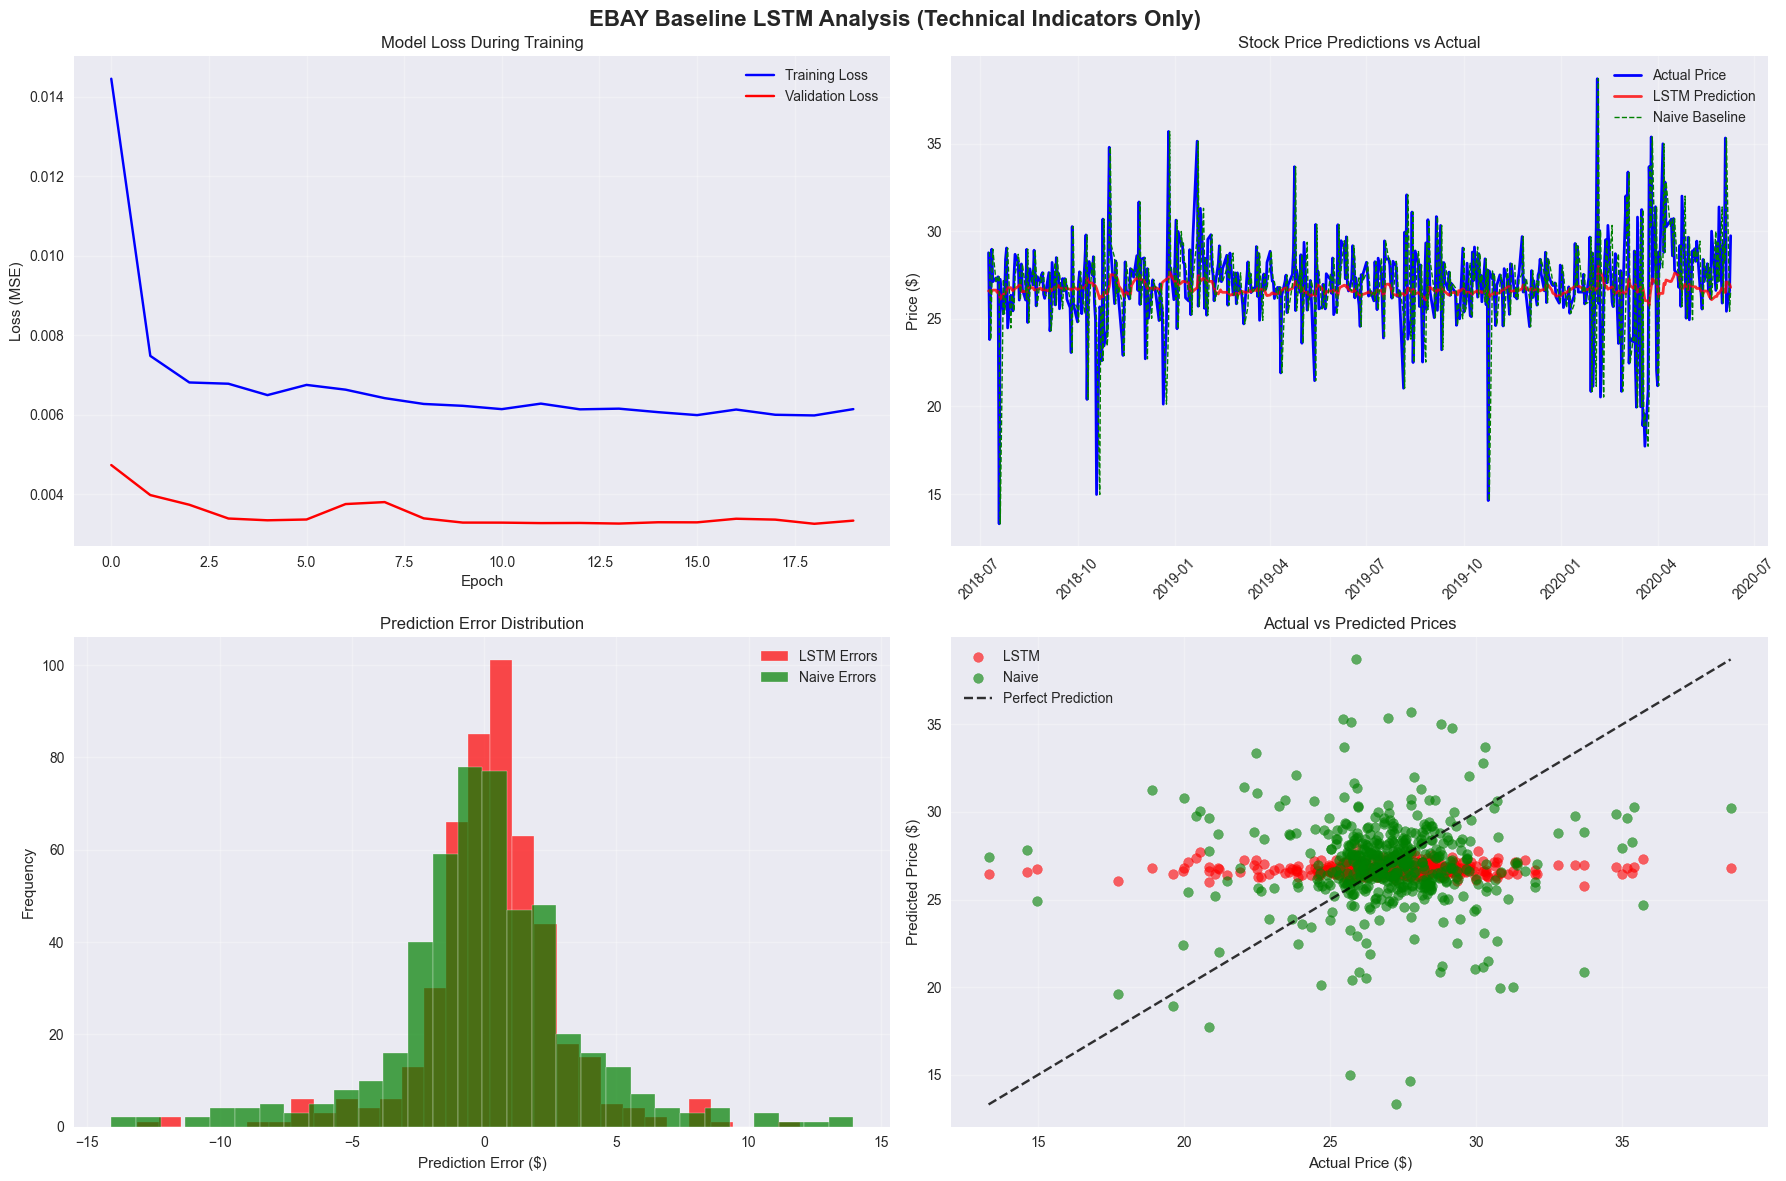


✅ Report 1 completed for EBAY
Baseline LSTM RMSE: $2.63
Baseline LSTM Directional Accuracy: 36.0%


In [19]:
# Visualization for baseline model
print("\n📊 Creating baseline model visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'{stock_symbol} Baseline LSTM Analysis (Technical Indicators Only)', fontsize=16, fontweight='bold')

# 1. Training history
axes[0, 0].plot(baseline_history.history['loss'], label='Training Loss', color='blue')
axes[0, 0].plot(baseline_history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Model Loss During Training')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Predictions vs Actual
test_dates = enhanced_data.index[-len(y_test_baseline_scaled):]
axes[0, 1].plot(test_dates, y_test_baseline_scaled, label='Actual Price', color='blue', linewidth=2)
axes[0, 1].plot(test_dates, baseline_test_predictions_scaled, label='LSTM Prediction', color='red', linewidth=2, alpha=0.8)
axes[0, 1].plot(test_dates, naive_predictions, label='Naive Baseline', color='green', linewidth=1, linestyle='--')
axes[0, 1].set_title('Stock Price Predictions vs Actual')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Prediction errors
lstm_errors = y_test_baseline_scaled.flatten() - baseline_test_predictions_scaled.flatten()
naive_errors = y_test_baseline_scaled.flatten() - naive_predictions.flatten()

axes[1, 0].hist(lstm_errors, bins=30, alpha=0.7, label='LSTM Errors', color='red')
axes[1, 0].hist(naive_errors, bins=30, alpha=0.7, label='Naive Errors', color='green')
axes[1, 0].set_title('Prediction Error Distribution')
axes[1, 0].set_xlabel('Prediction Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter plot: Actual vs Predicted
axes[1, 1].scatter(y_test_baseline_scaled, baseline_test_predictions_scaled, alpha=0.6, color='red', label='LSTM')
axes[1, 1].scatter(y_test_baseline_scaled, naive_predictions, alpha=0.6, color='green', label='Naive')
min_price = min(y_test_baseline_scaled.min(), baseline_test_predictions_scaled.min())
max_price = max(y_test_baseline_scaled.max(), baseline_test_predictions_scaled.max())
axes[1, 1].plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.8, label='Perfect Prediction')
axes[1, 1].set_title('Actual vs Predicted Prices')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Report 1 completed for {stock_symbol}")
print(f"Baseline LSTM RMSE: ${baseline_lstm_metrics['RMSE']:.2f}")
print(f"Baseline LSTM Directional Accuracy: {baseline_lstm_metrics['Directional_Accuracy']:.1f}%")


## 6. Report 2: Sentiment-Enhanced LSTM Model

This section implements the enhanced LSTM model that incorporates news sentiment as an additional predictive feature alongside technical indicators.


In [20]:
def create_enhanced_dataset(stock_data, daily_sentiment_df):
    """
    Creates an enhanced dataset with improved sentiment features:
    1. Adds a 'has_news' flag.
    2. Fills no-news days with 0 instead of forward-filling.
    3. Creates lagged sentiment features for historical context.
    """
    print("\n🔗 Creating sentiment-enhanced dataset (v2)...\n")

    if daily_sentiment_df is None or daily_sentiment_df.empty:
        return None

    # Create a date-based index on the stock data for joining
    enhanced_stock_data = stock_data.copy()
    enhanced_stock_data['Date'] = pd.to_datetime(enhanced_stock_data.index.date)
    enhanced_stock_data = enhanced_stock_data.set_index('Date')

    # Merge with sentiment data
    merged_data = enhanced_stock_data.join(daily_sentiment_df, how='left')

    # --- Improvement 1: Add 'has_news' flag and fill NaNs with 0 ---
    print("Handling no-news days by creating 'has_news' feature...")
    merged_data['has_news'] = np.where(merged_data['News_Count'].notna(), 1, 0)

    sentiment_cols = ['Avg_Sentiment', 'Sentiment_Ratio', 'News_Count', 'Positive_Count', 'Negative_Count']
    for col in sentiment_cols:
        if col in merged_data.columns:
            merged_data[col].fillna(0, inplace=True)

    # --- Improvement 2: Create lagged sentiment features ---
    print("Creating lagged sentiment features for historical context...")
    sentiment_cols_to_lag = ['Avg_Sentiment', 'Sentiment_Ratio', 'News_Count']
    for col in sentiment_cols_to_lag:
        for i in range(1, 4):  # Lags for 1, 2, and 3 days prior
            merged_data[f'{col}_lag_{i}'] = merged_data[col].shift(i)

    # Drop rows with NaN values created by the lagging process
    merged_data.dropna(inplace=True)

    print(f"\nEnhanced dataset shape: {merged_data.shape}")
    print("Sample of new features created:")
    display_cols = ['Close', 'Avg_Sentiment', 'has_news', 'Avg_Sentiment_lag_1', 'Sentiment_Ratio_lag_1']
    print(merged_data[display_cols].head())

    return merged_data


# Create enhanced dataset
enhanced_stock_data = create_enhanced_dataset(enhanced_data, daily_sentiment_df)



🔗 Creating sentiment-enhanced dataset (v2)...

Handling no-news days by creating 'has_news' feature...
Creating lagged sentiment features for historical context...

Enhanced dataset shape: (1074, 29)
Sample of new features created:
                Close  Avg_Sentiment  has_news  Avg_Sentiment_lag_1  \
Date                                                                  
2011-10-13  12.345052        -0.1938         1               0.0000   
2011-10-14  12.703260         0.3481         1              -0.1938   
2011-10-17  12.526043        -0.0032         1               0.3481   
2011-10-18  12.771132        -0.3715         1              -0.0032   
2011-10-19  12.510959         0.0491         1              -0.3715   

            Sentiment_Ratio_lag_1  
Date                               
2011-10-13               0.000000  
2011-10-14              -0.200000  
2011-10-17               0.333333  
2011-10-18               0.000000  
2011-10-19              -0.500000  


In [21]:
# Prepare enhanced data
if enhanced_stock_data is not None:
    print("\n🔧 Preparing enhanced LSTM data...")

    enhanced_features = [
        'Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread', 'Price_Change_Pct',
        'Avg_Sentiment', 'Sentiment_Ratio', 'News_Count'
    ]

    enhanced_target = 'Price_Change_Pct'

    X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced, scaler_enhanced = prepare_data_for_lstm(
        enhanced_stock_data,  # Your DataFrame with sentiment and tech indicators
        feature_columns=enhanced_features,
        target_column=enhanced_target,
        sequence_length=SEQUENCE_LENGTH,
        test_size=TEST_SIZE
    )

    if X_train_enhanced is not None:
        print(f"Enhanced Training data shape: X_train: {X_train_enhanced.shape}, y_train: {y_train_enhanced.shape}")
        print(f"Enhanced Testing data shape: X_test: {X_test_enhanced.shape}, y_test: {y_test_enhanced.shape}")
        # print(f"Enhanced features used: {feature_names_enhanced}")

        # Build enhanced model
        print("\n🏗️ Building sentiment-enhanced LSTM model...")
        enhanced_model = build_lstm_model((X_train_enhanced.shape[1], X_train_enhanced.shape[2]))
        print("Enhanced LSTM Model Architecture:")
        enhanced_model.summary()
    else:
        print("Failed to prepare enhanced data")
        enhanced_model = None
else:
    print("No enhanced stock data available")
    enhanced_model = None



🔧 Preparing enhanced LSTM data...
Enhanced Training data shape: X_train: (829, 30, 9), y_train: (829,)
Enhanced Testing data shape: X_test: (215, 30, 9), y_test: (215,)

🏗️ Building sentiment-enhanced LSTM model...
Enhanced LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train enhanced model
if enhanced_model is not None and X_train_enhanced is not None:
    print("\n🚀 Training sentiment-enhanced LSTM model...")

    # Train the enhanced model
    enhanced_history = enhanced_model.fit(
        X_train_enhanced, y_train_enhanced,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=[reduce_lr],
        # callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    print("Enhanced model training completed!")

    # Make enhanced predictions
    print("\n📊 Evaluating enhanced model...")
    enhanced_train_predictions = enhanced_model.predict(X_train_enhanced, verbose=0)
    enhanced_test_predictions = enhanced_model.predict(X_test_enhanced, verbose=0)

    # Inverse transform predictions and actual values
    enhanced_train_predictions_scaled = close_scaler.inverse_transform(enhanced_train_predictions)
    enhanced_test_predictions_scaled = close_scaler.inverse_transform(enhanced_test_predictions.reshape(-1, 1))
    y_train_enhanced_scaled = close_scaler.inverse_transform(y_train_enhanced.reshape(-1, 1))
    y_test_enhanced_scaled = close_scaler.inverse_transform(y_test_enhanced.reshape(-1, 1))

    # Calculate metrics for enhanced model
    enhanced_lstm_metrics = calculate_metrics(y_test_enhanced_scaled, enhanced_test_predictions_scaled, 'Enhanced LSTM')

    print("\n" + "=" * 70)
    print("📈 REPORT 2: STOCK FORECAST USING TECHNICAL INDICATORS AND NEWS SENTIMENT")
    print("=" * 70)

    # Create comprehensive comparison DataFrame
    all_metrics_df = pd.DataFrame([baseline_lstm_metrics, enhanced_lstm_metrics, naive_baseline_metrics])
    all_metrics_df = all_metrics_df.round(4)

    print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
    print("-" * 60)
    print(all_metrics_df.to_string(index=False))

    # Calculate improvements
    rmse_improvement_enhanced = ((baseline_lstm_metrics['RMSE'] - enhanced_lstm_metrics['RMSE']) /
                                 baseline_lstm_metrics['RMSE']) * 100
    directional_improvement_enhanced = enhanced_lstm_metrics['Directional_Accuracy'] - baseline_lstm_metrics[
        'Directional_Accuracy']

    print(f"\n📈 SENTIMENT ENHANCEMENT EFFECTIVENESS")
    print("-" * 40)
    print(f"RMSE Improvement over Baseline LSTM: {rmse_improvement_enhanced:.2f}%")
    print(f"Directional Accuracy Improvement: {directional_improvement_enhanced:.2f} percentage points")

    # Overall comparison with naive baseline
    rmse_improvement_vs_naive = ((naive_baseline_metrics['RMSE'] - enhanced_lstm_metrics['RMSE']) /
                                 naive_baseline_metrics['RMSE']) * 100
    directional_improvement_vs_naive = enhanced_lstm_metrics['Directional_Accuracy'] - naive_baseline_metrics[
        'Directional_Accuracy']

    print(f"\n📈 ENHANCED MODEL vs NAIVE BASELINE")
    print("-" * 40)
    print(f"RMSE Improvement over Naive Baseline: {rmse_improvement_vs_naive:.2f}%")
    print(f"Directional Accuracy Improvement: {directional_improvement_vs_naive:.2f} percentage points")

    # Determine effectiveness
    if rmse_improvement_enhanced > 5:
        print("\n✅ SIGNIFICANT IMPROVEMENT: News sentiment significantly enhances prediction accuracy")
    elif rmse_improvement_enhanced > 0:
        print("\n✅ MODEST IMPROVEMENT: News sentiment provides modest enhancement")
    elif rmse_improvement_enhanced > -2:
        print("\n⚠️  MINIMAL IMPACT: News sentiment has minimal impact on prediction accuracy")
    else:
        print("\n❌ NEGATIVE IMPACT: News sentiment appears to hurt prediction accuracy")

else:
    print("Enhanced model training skipped due to data preparation issues")
    enhanced_lstm_metrics = None
    enhanced_test_predictions_scaled = None
    y_test_enhanced_scaled = None



🚀 Training sentiment-enhanced LSTM model...
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.1144 - mae: 0.2788 - val_loss: 0.0070 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0154 - mae: 0.0940 - val_loss: 0.0128 - val_mae: 0.0884 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0101 - mae: 0.0741 - val_loss: 0.0108 - val_mae: 0.0774 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0101 - mae: 0.0739 - val_loss: 0.0084 - val_mae: 0.0632 - learning_rate: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0098 - mae: 0.0723 - val_loss: 0.0068 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0088 - mae: 0.0682 - val_loss: 0.0069 - val_mae: 0.0533 - learning_rate: 0.0010
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0092 - mae: 0.0716 - val_loss: 0.0060 - val_mae:


📊 Creating comprehensive model comparison visualizations...


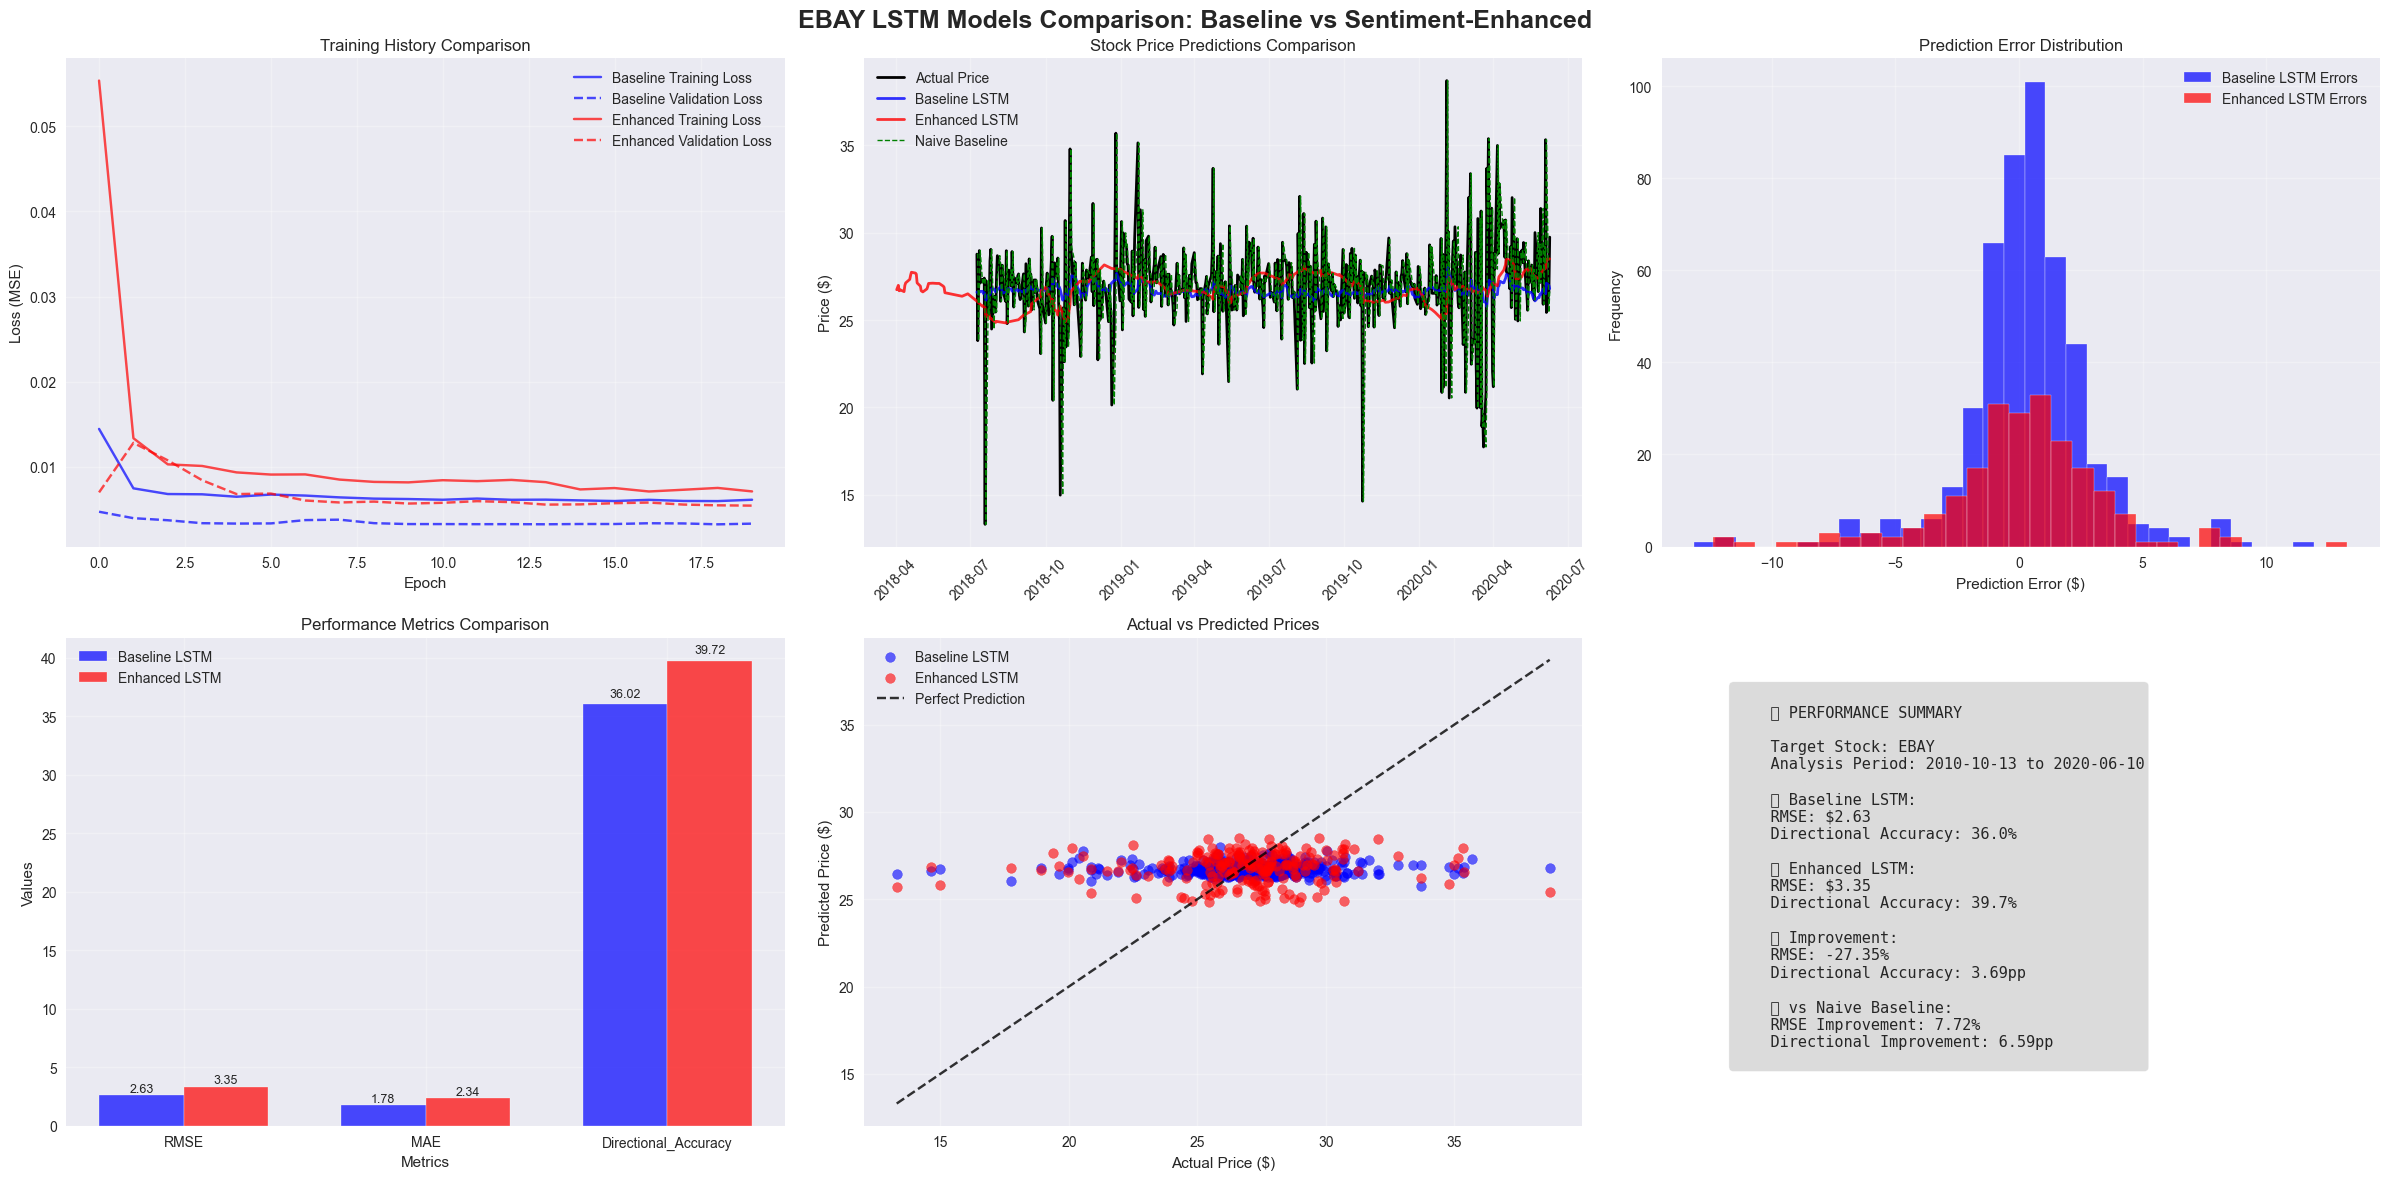


✅ Report 2 completed for EBAY
Enhanced LSTM RMSE: $3.35
Enhanced LSTM Directional Accuracy: 39.7%


In [23]:
# Comprehensive visualization comparing both models
if enhanced_model is not None and enhanced_test_predictions_scaled is not None:
    print("\n📊 Creating comprehensive model comparison visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    fig.suptitle(f'{stock_symbol} LSTM Models Comparison: Baseline vs Sentiment-Enhanced', fontsize=18, fontweight='bold')
    
    # 1. Training history comparison
    axes[0, 0].plot(baseline_history.history['loss'], label='Baseline Training Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(baseline_history.history['val_loss'], label='Baseline Validation Loss', color='blue', linestyle='--', alpha=0.7)
    axes[0, 0].plot(enhanced_history.history['loss'], label='Enhanced Training Loss', color='red', alpha=0.7)
    axes[0, 0].plot(enhanced_history.history['val_loss'], label='Enhanced Validation Loss', color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Training History Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Predictions comparison
    test_dates = enhanced_data.index[-len(y_test_baseline_scaled):]
    enhanced_test_dates = enhanced_stock_data.index[-len(y_test_enhanced_scaled):]
    axes[0, 1].plot(test_dates, y_test_baseline_scaled, label='Actual Price', color='black', linewidth=2)
    axes[0, 1].plot(test_dates, baseline_test_predictions_scaled, label='Baseline LSTM', color='blue', linewidth=2, alpha=0.8)
    axes[0, 1].plot(enhanced_test_dates, enhanced_test_predictions_scaled, label='Enhanced LSTM', color='red', linewidth=2, alpha=0.8)
    naive_predictions = np.roll(y_test_baseline_scaled, 1)
    naive_predictions[0] = y_test_baseline_scaled[0]
    axes[0, 1].plot(test_dates, naive_predictions, label='Naive Baseline', color='green', linewidth=1, linestyle='--')
    axes[0, 1].set_title('Stock Price Predictions Comparison')
    axes[0, 1].set_ylabel('Price ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Error comparison
    baseline_errors = y_test_baseline_scaled.flatten() - baseline_test_predictions_scaled.flatten()
    enhanced_errors = y_test_enhanced_scaled.flatten() - enhanced_test_predictions_scaled.flatten()
    
    axes[0, 2].hist(baseline_errors, bins=30, alpha=0.7, label='Baseline LSTM Errors', color='blue')
    axes[0, 2].hist(enhanced_errors, bins=30, alpha=0.7, label='Enhanced LSTM Errors', color='red')
    axes[0, 2].set_title('Prediction Error Distribution')
    axes[0, 2].set_xlabel('Prediction Error ($)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Performance metrics comparison
    metrics_comparison = pd.DataFrame([baseline_lstm_metrics, enhanced_lstm_metrics])
    metrics_for_plot = metrics_comparison[['RMSE', 'MAE', 'Directional_Accuracy']]
    
    x_pos = np.arange(len(metrics_for_plot.columns))
    width = 0.35
    
    axes[1, 0].bar(x_pos - width/2, metrics_for_plot.iloc[0], width, label='Baseline LSTM', color='blue', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, metrics_for_plot.iloc[1], width, label='Enhanced LSTM', color='red', alpha=0.7)
    axes[1, 0].set_title('Performance Metrics Comparison')
    axes[1, 0].set_xlabel('Metrics')
    axes[1, 0].set_ylabel('Values')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(metrics_for_plot.columns)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (baseline_val, enhanced_val) in enumerate(zip(metrics_for_plot.iloc[0], metrics_for_plot.iloc[1])):
        axes[1, 0].text(i - width/2, baseline_val + baseline_val*0.01, f'{baseline_val:.2f}', 
                       ha='center', va='bottom', fontsize=9)
        axes[1, 0].text(i + width/2, enhanced_val + enhanced_val*0.01, f'{enhanced_val:.2f}', 
                       ha='center', va='bottom', fontsize=9)
    
    # 5. Scatter plot comparison
    axes[1, 1].scatter(y_test_baseline_scaled, baseline_test_predictions_scaled, alpha=0.6, color='blue', label='Baseline LSTM')
    axes[1, 1].scatter(y_test_enhanced_scaled, enhanced_test_predictions_scaled, alpha=0.6, color='red', label='Enhanced LSTM')
    min_price = min(y_test_baseline_scaled.min(), enhanced_test_predictions_scaled.min())
    max_price = max(y_test_baseline_scaled.max(), enhanced_test_predictions_scaled.max())
    axes[1, 1].plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.8, label='Perfect Prediction')
    axes[1, 1].set_title('Actual vs Predicted Prices')
    axes[1, 1].set_xlabel('Actual Price ($)')
    axes[1, 1].set_ylabel('Predicted Price ($)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Improvement summary
    axes[1, 2].axis('off')
    summary_text = f"""
    📊 PERFORMANCE SUMMARY
    
    Target Stock: {stock_symbol}
    Analysis Period: {START_DATE} to {END_DATE}
    
    🔹 Baseline LSTM:
    RMSE: ${baseline_lstm_metrics['RMSE']:.2f}
    Directional Accuracy: {baseline_lstm_metrics['Directional_Accuracy']:.1f}%
    
    🔹 Enhanced LSTM:
    RMSE: ${enhanced_lstm_metrics['RMSE']:.2f}
    Directional Accuracy: {enhanced_lstm_metrics['Directional_Accuracy']:.1f}%
    
    🔹 Improvement:
    RMSE: {rmse_improvement_enhanced:.2f}%
    Directional Accuracy: {directional_improvement_enhanced:.2f}pp
    
    🔹 vs Naive Baseline:
    RMSE Improvement: {rmse_improvement_vs_naive:.2f}%
    Directional Improvement: {directional_improvement_vs_naive:.2f}pp
    """
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, fontsize=11,
                    verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Report 2 completed for {stock_symbol}")
    print(f"Enhanced LSTM RMSE: ${enhanced_lstm_metrics['RMSE']:.2f}")
    print(f"Enhanced LSTM Directional Accuracy: {enhanced_lstm_metrics['Directional_Accuracy']:.1f}%")

else:
    print("Comprehensive visualization skipped due to enhanced model issues")